# ***Tutorial on Graph Neural Networks for point cloud classification***

### Learn how to implement Graph Neural Networks with Pytorch-Geometric to classify 3D point clouds

Author: Pablo Villanueva Domingo

Date: June 2022

## TO DO

* First layer with more channels
* Rotate in 2d plane
* Use max pooling

### Write

* Remove unnecesary pooling
* Remove numpy

# Preliminaries

Install the required packages to deal with graph data. These are extensions to Pytorch: torch-geometric, torch_cluster and torch_scatter.
The easiest way to install them is using conda, but in Google Collab you can just use the lines below.


In [1]:
"""
# Uncomment to install the required pytorch geometric and related packages
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.11.0+cu113.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-1.11.0+cu113.html
!pip install torch-geometric
"""

# Import required packages
%matplotlib inline
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric import nn
from torch_cluster import radius_graph

#from IPython.display import Javascript
#display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

# use GPUs if available
if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device('cuda')
else:
    print('CUDA Not Available')
    device = torch.device('cpu')

# Random seed
torch.manual_seed(12345)
np.random.seed(12345)

CUDA Available


# Loading and processing the dataset

For our example, we will use the [Modelnet10](https://modelnet.cs.princeton.edu/) dataset, a collection of 3D CAD models widely used as benchmark for point cloud classification. This dataset includes objects of 10 categories, such as chairs, beds, tables or toilets.

Pytorch-Geometric easily allows us to download the training and validation datasets.

In [2]:
from torch_geometric.datasets import ModelNet

train_dataset = ModelNet(root='data/ModelNet',train=True)
valid_dataset = ModelNet(root='data/ModelNet',train=False)

print("Number of 3D objects in the training dataset:",len(train_dataset))
print("Number of 3D objects in the training dataset:",len(valid_dataset))

Number of 3D objects in the training dataset: 3991
Number of 3D objects in the training dataset: 908


We can check the different categories of furniture by listing the data directories.

In [3]:
import os

folder = "data/ModelNet/raw/"
[f.path.replace(folder,"") for f in os.scandir(folder) if f.is_dir()]

['table',
 'dresser',
 'monitor',
 'night_stand',
 'chair',
 'bed',
 'sofa',
 'desk',
 'bathtub',
 'toilet']

The 3D objects in the dataset are 3D meshes, composed by vertexes and triangles. Instead of using meshes, we will sample points for each 3D model and treat them as point clouds.

They are given in terms of the pytorch-geometric datatype `Data`, which easily allows to work with graphs.

Note that each of these models contains several entries, such as the position of the vertices (`pos`), the triangular faces of the mesh (`face`) and the category, given by an integer (`y`).

In [4]:
print("Data:",train_dataset[0])

Data: Data(pos=[4574, 3], face=[3, 3826], y=[1])


Lets create a routine to visualize some of these point clouds and graphs.

In [5]:
# Visualization routine for plotting graphs
def visualize_graph(pos, edge_index=None):

    fig = plt.figure(figsize=(4, 4))

    ax = fig.add_subplot(projection ="3d")

    # Draw lines for each edge
    if edge_index is not None:
        for (src, dst) in edge_index.t().tolist():

            src = pos[src].tolist()
            dst = pos[dst].tolist()

            ax.plot([src[0], dst[0]], [src[1], dst[1]], zs=[src[2], dst[2]], linewidth=0.1, color='black')
            
    # Plot nodes
    ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2], s=1, zorder=1000)

    plt.show()

Instead of using meshes and all the points contained in the 3D models, we can sample a set of points from each object to generate a point cloud, using less resources. Pytorch-geometric has a functionality for that.

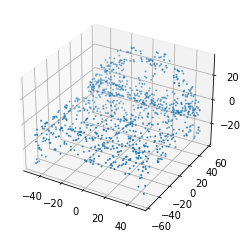

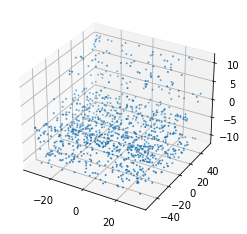

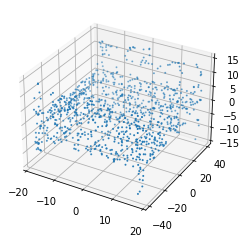

In [6]:
from torch_geometric.transforms import SamplePoints

numpoints = 1024

# Running samplepnts over a data instance would remove the faces and replace the vertices with a new set of 1024 sampled points
samplepnts = SamplePoints(num=numpoints)

# Visualize some point clouds
for i in range(107,110):
    data = train_dataset[i]
    data = samplepnts(data)
    visualize_graph(data.pos)

We can build graphs from a point cloud following a simple criterion. We consider two nodes as neighbors if they are separated by a distance smaller than a given connectivity radius. In that case, we set an edge between both nodes.

We can now further preprocess the point clouds, normalizing the points with respect to their standard deviation. Note that this make the data insensitive to the volume of the object, and thus scale invariant.

In [7]:
# Connectivity radius
r_link = 0.3

# Routine to preprocess data
# Sample point clouds, normalize and build the graph
def preprocess_dataset(dataset):

    newdataset = []

    for data in dataset:
        
        # Sample points
        sampled_data = samplepnts(data)
        
        sampled_data.pos = sampled_data.pos - torch.mean(sampled_data.pos,0)
        
        sampled_data.pos /= torch.std(sampled_data.pos)
        
        # Build the graph and get the edges
        sampled_data.edge_index = radius_graph(sampled_data.pos, r=r_link, loop=False)

        newdataset.append(sampled_data)

    return newdataset

train_dataset = preprocess_dataset(train_dataset)
valid_dataset = preprocess_dataset(valid_dataset)

Lets visualize some of these graphs.

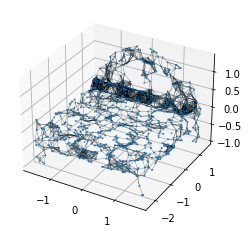

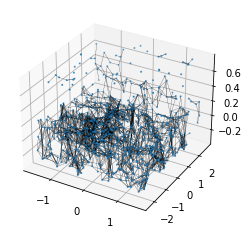

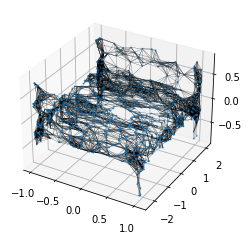

In [9]:
#"""
for i in range(107,110):
    data = train_dataset[i]
    visualize_graph(data.pos, data.edge_index)
#"""

The connectivity radius is an hyperparameter which has to be tuned. It has an important impact in the accuracy of the GNNs, since it determines the size of neighborhoods. To further understand, we can compute the mean degree of the nodes, which is the mean number of neighbors in the graphs.

In [10]:
from torch_geometric.utils import degree

mean_neigh = []
for data in train_dataset:
    deg = degree(data.edge_index[0], data.pos.shape[0])
    mean_neigh.extend(deg)
mean_neigh = torch.tensor(mean_neigh)
mean_neigh.mean(), mean_neigh.std()

(tensor(10.2802), tensor(5.9848))

To sample data for training and validation, lets convert the datasets to pytorch-geometric dataloaders, which are equivalent to standard pytorch dataloaders.

In [11]:
batch_size = 15

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

# Defining the network architecture

GNNs work with node features and edge features.

$\textbf{e}_{ij}^{(l+1)}=\phi_{l+1} \left([\textbf{h}_i^{(l)},\textbf{h}_j^{(l)},\textbf{e}_{ij}^{(l)}]\right)$

$\textbf{h}_i^{(l+1)} = \psi_{l+1} \left([\textbf{h}_i^{(l)}, \bigoplus_{j \in \mathcal{N}_i} \textbf{e}_{ij}^{(l+1)}]\right)$

After $L$ graph blocks, we aggregate the hidden activations of all nodes, performing a pooling operation. This step must also be a permutation invariant operation, such as the mean, maximum or sum.
A final MLP, $\xi$, is fed by the result of this pooling operation, and outputs an array of category probabilities, $\textbf{y}$:

$\textbf{y} = \xi \left( \bigoplus_{i \in \mathcal{G}} \textbf{h}_i^{(L)} \right)$

In [12]:
from torch.nn import Sequential, Linear, ReLU, ModuleList
from torch_geometric.nn import MetaLayer
from torch_scatter import scatter_add, scatter_max
from torch_geometric.nn import global_add_pool, global_mean_pool, global_max_pool
from torch_geometric.nn import GraphNorm


# Model for updating edge attributes
class EdgeModel(torch.nn.Module):
    def __init__(self, node_in, node_out, edge_in, edge_out, hid_channels, residuals=False):
        super().__init__()

        # Boolean to sum residuals or not
        self.residuals = residuals
        self.node_in = node_in

        layers = [Linear(node_in*2 + edge_in, hid_channels),
                  ReLU(),
                  Linear(hid_channels, edge_out)]
            
        # Use normalization layer
        if normlayer:  layers.append(GraphNorm(edge_out))

        self.edge_mlp = Sequential(*layers)


    def forward(self, src, dest, edge_attr, u, batch):
        # src, dest: h_i, h_j, shape: [num edges, node features channels]
        # edge_attr: e_ij, shape: [num edges, edge features channels]
        # u: global features, not used here
        # batch: not needed

        # Concatenate [h_i, h_j, e_ij]
        out = torch.cat([src, dest, edge_attr], dim=1)
        
        # Feed into a MLP an update edge features
        out = self.edge_mlp(out)

        # Add residuals
        if self.residuals:
            out = out + edge_attr

        return out

# Model for updating node attritbutes
class NodeModel(torch.nn.Module):
    def __init__(self, node_in, node_out, edge_in, edge_out, hid_channels, residuals=False):
        super().__init__()

        self.residuals = residuals
        self.node_in = node_in

        layers = [Linear(node_in + edge_out, hid_channels),
                  ReLU(),
                  Linear(hid_channels, node_out)]
            
        if normlayer:  layers.append(GraphNorm(node_out))

        self.node_mlp = Sequential(*layers)

    def forward(self, x, edge_index, edge_attr, u, batch):
        # x: [num nodes, node channels]
        # edge_index: [2, num edges]
        # edge_attr: [num edges, edge channels]
        # u: global features, not used
        # batch: not needed

        # Get nodes i and j
        row, col = edge_index

        # Aggregate information over neighbors
        #aggr = scatter_add(edge_attr, col, dim=0, dim_size=x.size(0))
        aggr = scatter_max(edge_attr, col, dim=0, dim_size=x.size(0))[0]
        
        # Concatenate h_i and \sum_j h_j
        out = torch.cat([x, aggr], dim=1)

        # Feed into a MLP an update node features
        out = self.node_mlp(out)

        # Add residuals
        if self.residuals:
            out = out + x

        return out

# Graph Neural Network architecture, based on the Graph Network (arXiv:1806.01261)
# Employing the MetaLayer implementation in Pytorch-Geometric
class GNN(torch.nn.Module):
    def __init__(self, node_features, n_layers, hidden_channels, dim=3, dim_out=10):
        super().__init__()

        # Number of graph blocks
        self.n_layers = n_layers
        # Dimension of data (3 for ModelNet10)
        self.dim = dim
        # Dimension of outputs, number of categories (10 for ModelNet10)
        self.dim_out = dim_out
        # Number of input node features: relative position wrt center of mass and its norm
        node_in = self.dim + 1
        # Input edge features: relative position vector between two nodes and its norm
        edge_in = self.dim + 1
        # Dimensions for hidden node and edge features
        node_out = hidden_channels
        edge_out = hidden_channels
        hid_channels = hidden_channels
        # Do not use residuals for first layer
        residuals = False

        layers = []

        # Define graph blocks
        for i in range(n_layers):

            lay = MetaLayer(node_model=NodeModel(node_in, node_out, edge_in, edge_out, hid_channels, residuals),
                            edge_model=EdgeModel(node_in, node_out, edge_in, edge_out, hid_channels, residuals))
            layers.append(lay)
            node_in = node_out
            edge_in = edge_out
            residuals = True
            #if==0:
            #    hidden_channels = hidden_channels//2
 

        self.layers = ModuleList(layers)

        # Final aggregation layer
        self.outlayer = Sequential(Linear(node_out, hid_channels),
                              ReLU(),
                              Linear(hid_channels, hid_channels),
                              ReLU(),
                              Linear(hid_channels, hid_channels),
                              ReLU(),
                              Linear(hid_channels, self.dim_out))


    def forward(self, data):

        # Get data
        pos, edge_index, batch = data.pos, data.edge_index, data.batch
                
        # Define node features as relative positions wrt the center of mass and their norm
        pos_com = torch.mean(pos, 0)
        relpos = pos - pos_com
        relpos_norm = torch.norm(relpos, dim=1, keepdim=True)
        h = torch.cat([relpos, relpos_norm],dim=1)
        
        # Define edge features as relative positions between points and their norm, normalized by the connectivity radius
        row, col = edge_index
        diffvec = (pos[row]-pos[col])/r_link
        diffvec_norm = torch.norm(diffvec, dim=1, keepdim=True)
        edge_attr = torch.cat([diffvec, diffvec_norm],dim=1)

        # Message passing layers
        # Feed the node and edge features through different graph blocks and get their hidden activations
        # The "None" argument and "_" output are global features of the graph, which we do not use for simplicity
        for layer in self.layers:
            h, edge_attr, _ = layer(h, edge_index, edge_attr, None, batch)

        # Multipooling layer
        #out = global_mean_pool(h, batch)
        out = global_max_pool(h, batch)

        # Final linear layer
        out = self.outlayer(out)

        return out

n_layers = 3
hidden_channels = 256
#invgnn = True
invgnn = False

normlayer=True

# Initialize model
model = GNN(node_features=4,
            n_layers=n_layers,
            hidden_channels=hidden_channels)
print(model)
model.to(device)

GNN(
  (layers): ModuleList(
    (0): MetaLayer(
      edge_model=EdgeModel(
      (edge_mlp): Sequential(
        (0): Linear(in_features=12, out_features=256, bias=True)
        (1): ReLU()
        (2): Linear(in_features=256, out_features=256, bias=True)
        (3): GraphNorm(256)
      )
    ),
      node_model=NodeModel(
      (node_mlp): Sequential(
        (0): Linear(in_features=260, out_features=256, bias=True)
        (1): ReLU()
        (2): Linear(in_features=256, out_features=256, bias=True)
        (3): GraphNorm(256)
      )
    ),
      global_model=None
    )
    (1): MetaLayer(
      edge_model=EdgeModel(
      (edge_mlp): Sequential(
        (0): Linear(in_features=768, out_features=256, bias=True)
        (1): ReLU()
        (2): Linear(in_features=256, out_features=256, bias=True)
        (3): GraphNorm(256)
      )
    ),
      node_model=NodeModel(
      (node_mlp): Sequential(
        (0): Linear(in_features=512, out_features=256, bias=True)
        (1): ReLU()

GNN(
  (layers): ModuleList(
    (0): MetaLayer(
      edge_model=EdgeModel(
      (edge_mlp): Sequential(
        (0): Linear(in_features=12, out_features=256, bias=True)
        (1): ReLU()
        (2): Linear(in_features=256, out_features=256, bias=True)
        (3): GraphNorm(256)
      )
    ),
      node_model=NodeModel(
      (node_mlp): Sequential(
        (0): Linear(in_features=260, out_features=256, bias=True)
        (1): ReLU()
        (2): Linear(in_features=256, out_features=256, bias=True)
        (3): GraphNorm(256)
      )
    ),
      global_model=None
    )
    (1): MetaLayer(
      edge_model=EdgeModel(
      (edge_mlp): Sequential(
        (0): Linear(in_features=768, out_features=256, bias=True)
        (1): ReLU()
        (2): Linear(in_features=256, out_features=256, bias=True)
        (3): GraphNorm(256)
      )
    ),
      node_model=NodeModel(
      (node_mlp): Sequential(
        (0): Linear(in_features=512, out_features=256, bias=True)
        (1): ReLU()

# Training routines

In [16]:
from tqdm import tqdm
from scipy.spatial.transform import Rotation as Rot

epochs = 100
learning_rate = 1.e-6
noise_std = 0.05
weight_decay = 1.e-6


# Apply random distortions in the position of the nodes
def jitter(data, noise_std, device=device):
    clip = 3.*noise_std
    noise = torch.randn(data.pos.shape[0],data.pos.shape[1],device=device)
    noise = torch.clip(noise_std*noise, -clip, clip)
    data.pos = data.pos + noise
    return data

# Train on one epoch
def train(loader, model, criterion, optimizer, scheduler):
    model.train()

    loss_tot = 0
    pbar = tqdm(loader, total=len(loader), position=0, leave=True, desc=f"Training")
    for data in pbar:
         
        data.to(device)
        data = jitter(data, noise_std)
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()
        loss_tot += loss.item()

    return loss_tot/len(loader)

# Test the model
@torch.no_grad()
def test(loader, model, criterion):
    model.eval()

    total, correct = 0, 0
    loss_tot = 0
    for data in loader:

        data.to(device)
        #if data_aug:
        #    data = random_rotate(data)

        out = model(data)
        loss = criterion(out, data.y)
        _, predicted = torch.max(out, 1)
        total += data.y.size(0)
        correct += (predicted == data.y).sum().item()
        loss_tot += loss.item()

    accuracy = correct/total

    return loss_tot/len(loader), accuracy


In [ ]:
# GNN
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=learning_rate, max_lr=learning_rate*1.e3, cycle_momentum=False)
criterion = torch.nn.CrossEntropyLoss()

namerun = "relpos_std_npoints_{:d}_rlink_{:.2e}_layers_{:d}_channels_{:d}_inv_{:d}_batch_{:d}_noise_{:.2e}_weightdecay_{:.2e}".format(numpoints, r_link, n_layers, hidden_channels, invgnn, batch_size, noise_std, weight_decay)
bestmodelname = "models/model_"+namerun+".pt"

load_best = False
if load_best:
    print("Loading previous model")
    state_dict = torch.load(bestmodelname, map_location=device)
    model.load_state_dict(state_dict)

train_losses, test_losses, accuracies = [], [], []
#valid_loss_min = 1.e5
max_acc = 0.

for epoch in range(1, epochs+1):
    train_loss = train(train_loader, model, criterion, optimizer, scheduler)
    valid_loss, accuracy = test(valid_loader, model, criterion)
    train_losses.append(train_loss); test_losses.append(valid_loss); accuracies.append(accuracy)
    if max_acc <= accuracy:
        max_acc = accuracy
        torch.save(model.state_dict(), bestmodelname)
    print(f'Epoch: {epoch:03d}, Training Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}, Accuracy: {accuracy:.4f}')
print("Maximum accuracy:", max_acc)

Training: 100%|██████████████████████████████████████████████████████████████████████████| 267/267 [01:36<00:00,  2.76it/s]


Epoch: 001, Training Loss: 0.4614, Validation Loss: 0.5964, Accuracy: 0.7952


Training: 100%|██████████████████████████████████████████████████████████████████████████| 267/267 [01:39<00:00,  2.67it/s]


Epoch: 002, Training Loss: 0.4360, Validation Loss: 0.4622, Accuracy: 0.8337


Training: 100%|██████████████████████████████████████████████████████████████████████████| 267/267 [01:40<00:00,  2.67it/s]


Epoch: 003, Training Loss: 0.3934, Validation Loss: 0.5346, Accuracy: 0.8293


Training: 100%|██████████████████████████████████████████████████████████████████████████| 267/267 [01:39<00:00,  2.68it/s]


Epoch: 004, Training Loss: 0.3449, Validation Loss: 0.5511, Accuracy: 0.8139


Training: 100%|██████████████████████████████████████████████████████████████████████████| 267/267 [01:39<00:00,  2.69it/s]


Epoch: 005, Training Loss: 0.3764, Validation Loss: 0.5155, Accuracy: 0.8117


Training: 100%|██████████████████████████████████████████████████████████████████████████| 267/267 [01:38<00:00,  2.72it/s]


Epoch: 006, Training Loss: 0.3400, Validation Loss: 0.4992, Accuracy: 0.8315


Training: 100%|██████████████████████████████████████████████████████████████████████████| 267/267 [01:36<00:00,  2.78it/s]


Epoch: 007, Training Loss: 0.3395, Validation Loss: 0.4915, Accuracy: 0.8216


Training: 100%|██████████████████████████████████████████████████████████████████████████| 267/267 [01:34<00:00,  2.81it/s]


Epoch: 008, Training Loss: 0.3174, Validation Loss: 0.4123, Accuracy: 0.8546


Training: 100%|██████████████████████████████████████████████████████████████████████████| 267/267 [01:33<00:00,  2.84it/s]


Epoch: 009, Training Loss: 0.2744, Validation Loss: 0.4418, Accuracy: 0.8458


Training: 100%|██████████████████████████████████████████████████████████████████████████| 267/267 [01:33<00:00,  2.86it/s]


Epoch: 010, Training Loss: 0.2349, Validation Loss: 0.4006, Accuracy: 0.8590


Training: 100%|██████████████████████████████████████████████████████████████████████████| 267/267 [01:34<00:00,  2.83it/s]


Epoch: 011, Training Loss: 0.1973, Validation Loss: 0.3599, Accuracy: 0.8744


Training: 100%|██████████████████████████████████████████████████████████████████████████| 267/267 [01:34<00:00,  2.83it/s]


Epoch: 012, Training Loss: 0.1587, Validation Loss: 0.3183, Accuracy: 0.8855


Training:  87%|████████████████████████████████████████████████████████████████          | 231/267 [01:21<00:12,  2.84it/s]

In [ ]:
plt.plot(train_losses, "r-",label="Training")
plt.plot(test_losses, "b:",label="Validation")
plt.grid()
plt.legend()
plt.savefig("loss_"+namerun+".png")

In [ ]:
plt.plot(accuracies, "r-",label="Accuracy")
plt.grid()
plt.ylim(0.5,1.)
plt.yticks(np.linspace(0.5, 1., 11))
plt.legend()
plt.savefig("acc_"+namerun+".png")

In [ ]:
data = next(iter(valid_loader))
data.to(device)
out = model(data)
pred, _ = torch.max(out, 1)
print(pred)

In [ ]:
valid_loss , valid_loss_min